<a href="https://colab.research.google.com/github/guillermohenrion/AI/blob/master/semantic_word_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Estudio de los textos de Hayek realizando un LDA, asignando semántica a las componentes dentro del espacio semántico según una word embedding y viendo la posición de cada documento. Similarmente para bigramas.

##Instalar e importar paquetes

In [1]:
!pip install nltk==3.5
!pip install gensim==4.1.2
!pip install spacy==3.1.5
!pip install pyLDAvis==3.2.1
!python -m spacy download es_core_news_sm
!python -m spacy download fr_core_news_sm
# !pip install feedparser
# !pip install gspan


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.2 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434693 sha256=494cba29b5f0738bf7f35179c6358eb54e14ca9d77f970247f5748592e091c43
  Stored in directory: /root/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136187 sha256=b98a7181541d1ce3ae6d382e2078adab1d9d0accb39904293fbaba0adcc357f7
  Stored in directory: /root/.cache/pip/wheels/c6/ee/a6/7c17a63623f940dff0b9cbd7e48a27543f088fa55a7d2b62d0
Successfully built pyLDAvis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.7 MB 4.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.1 MB 565 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [2]:
import nltk
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import random
import pandas as pd

import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
# from gensim.models.wrappers import LdaMallet, ldamallet
from gensim.corpora import Dictionary
import spacy

import csv
from unicodedata import normalize
import string
from wordcloud import WordCloud, STOPWORDS 
 
from sklearn.manifold import TSNE
#import gspan

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import es_core_news_sm
nlp = es_core_news_sm.load()

In [4]:
#!ls *.txt


#Leer documentos y procesar a txt

In [91]:
# '14_many_newlines_removed.txt'
# nombres_textos=['individualismo.txt','Hayek - A dónde va la democracia.txt','Hayek - Los principios de un orden social liberal.txt',
#               'Hayek - El uso del conocimiento en la sociedad.txt','Hayek - La fatal arrogancia. Los errores del socialismo.txt',
#              'Hayek - Camino de servidumbre.txt','Hayek - Precios y Producción.txt','Hayek - El mensaje de Adam Smith en el lenguaje actual.txt']

# nombres_textos=['Hayek - Individualismo.txt','Hayek - La fatal arrogancia. Los errores del socialismo.txt']

nombres_textos=['txts/Hayek - A donde va la democracia.txt', #1
              'txts/Hayek - Camino de servidumbre.txt', #1
              'txts/Hayek - El uso del conocimiento en la sociedad.txt', #1
              'txts/Hayek - Individualismo: El verdadero y el falso.txt', #1  
              'txts/Hayek - Precios y Produccion.txt', #1
              'txts/Hayek - La fatal arrogancia. Los errores del socialismo.txt',#2
              'txts/Hayek - Liberalismo.txt', #2
              'txts/Hayek - Los Fundamentos de la Libertad.txt', #2
              'txts/Hayek - Los principios de un orden social liberal.txt', #2
              'txts/Hayek - El mensaje de Adam Smith en el lenguaje actual.txt' #2
              ]
                
                #'txts/Hayek - A donde va la democracia.txt', #1944
                #'txts/Hayek - El mensaje de Adam Smith en el lenguaje actual.txt', #1976
                #'txts/Hayek - El uso del conocimiento en la sociedad.txt', #1945
                #'txts/Hayek - Individualismo.txt', # 1948
                #'txts/Hayek - Liberalismo.txt',  # 1973
                #'txts/Hayek - Los principios de un orden social liberal.txt', #1966
                #'txts/Hayek - Precios y Produccion.txt']  #1931

#'Hayek - Los Fundamentos de la Libertad.txt' da error en el preprocesamiento por superar 1M de caracteres

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
# !cp -r "drive/MyDrive/Colab Notebooks/Historical Text Analytics/Hayek - Camino de servidumbre/" /content
!rsync -aP "drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/txts" /content

sending incremental file list


In [94]:
import pandas as pd
doct=pd.DataFrame(columns=["Nombre", "Texto"])


In [95]:
doc=[]

for r in nombres_textos:
    with open(r,'r',encoding='iso-8859-1') as f:
        print(r)
        doc1=f.read()
        if (r=='txts/Hayek - Camino de servidumbre.txt'):
          doc1=doc1[193803:639188]
        doc.append(doc1)
        df2 = {'Nombre': r, 'Texto': doc1}
        doct=doct.append(df2, ignore_index = True)


txts/Hayek - A donde va la democracia.txt
txts/Hayek - Camino de servidumbre.txt
txts/Hayek - El uso del conocimiento en la sociedad.txt
txts/Hayek - Individualismo: El verdadero y el falso.txt
txts/Hayek - Precios y Produccion.txt
txts/Hayek - La fatal arrogancia. Los errores del socialismo.txt
txts/Hayek - Liberalismo.txt
txts/Hayek - Los Fundamentos de la Libertad.txt
txts/Hayek - Los principios de un orden social liberal.txt
txts/Hayek - El mensaje de Adam Smith en el lenguaje actual.txt


In [90]:
#from os import listdir
#from os.path import isfile, join

#nombres_libros=['txts/Hayek - Camino de servidumbre',
#                'txts/Hayek - La fatal arrogancia. Los errores del socialismo',
#                'txts/Hayek - Los Fundamentos de la Libertad']

#for l in nombres_libros:
#    carpeta=l
    # carpeta_drive="drive/MyDrive/Colab Notebooks/"+carpeta
    # !cp -r carpeta_drive /content
#    nombres_capitulos = [f for f in listdir(carpeta) if isfile(join(carpeta, f))]
#    nombres_capitulos = [k for k in nombres_capitulos if 'txt' in k]
    
   #     print(l)
#    for r in nombres_capitulos:
#        with open(f'{l}/'+r,'r',encoding='utf-8') as f:
#            doc1=f.read()
#            doc.append(doc1)
#            df2 = {'Nombre': r, 'Texto': doc1}
#            doct=doct.append(df2, ignore_index = True)


In [28]:
#doct.loc[doct['Nombre'] == "txts/Hayek - A donde va la democracia.txt"]


In [96]:
def preprocessing(text,stopwords):
    text = text.lower()  # texto a minúsculas
    text = re.sub(r'\[.*?¿\]%', ' ', text)  # Se remueven corchetes
    text = re.sub(r'\(.*?¿\)%', ' ', text)  # Se remueven parentesis
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # Se remueven signos de puntuación
    text = re.sub(r'\w*\d\w*', '', text)  # Se remueven palabras que contienen dígitos.
    text = re.sub(r'\n', ' ', text)  # Sustituye nueva línea por un espacio
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Sustituye los múltiples espacios por sólo un espacio
    text = re.sub(r'[‘’“”…«»°*_/¿¡!?]', '', text)  # Remueve otros caracteres no sintácticos
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+|\u20AC", r"\1",
                  normalize("NFD", text), 0, re.I)  # NFD y eliminar diacríticos y símbolo euro
    text = normalize('NFC', text)  # NFC
    bigram_list = bigram[text.split()]
    out_text = lemmatization(' '.join(bigram_list), allowed_postags=['NOUN'])  # ,'VERB','ADJ', 'PROPN'
    text_non_stop = [word for word in out_text if word not in stopwords]

    return text_non_stop

def lemmatization(texts, allowed_postags=None):
    if allowed_postags is None:
        allowed_postags = ['NOUN']
    texts_out = [token.lemma_ for token in nlp(texts) if token.pos_ in allowed_postags]
                 #allowed_postags and token.text not in black_list and len(token.text) > 2]
    return texts_out


def display_topics(model, model_type='lda'):
    for topic_idx, topic in enumerate(model.print_topics()):
        print('Topic %d:' % topic_idx)
        if model_type == 'hdp':
            print(" ".join(re.findall(r'\*(.[^\*-S]+).?', topic[1])), '\n')
        else:
            print(" ".join(re.findall(r'\"(.[^"]+).?', topic[1])), '\n')

def format_topics_sentences(ldamodel=0, corpus=[], texts=0):
    sent_topics_df = pd.DataFrame()  # - n

    # Tema principal en cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Tema dominante, porcentaje de contribución y palabras claves
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Tema dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Agrega el texto original al final
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

#BOW

In [97]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=100)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=100)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

In [98]:
stopwords = nltk.corpus.stopwords.words('spanish')
bigram = gensim.models.Phrases(doc, min_count=5, threshold=2.0)
stopwords.extend(['d', 'd', 'h', 'l','n', 'c', 'ta','s','p', 'r', 'vez','pagina','parte','ejemplo','medida','modo','tipo','forma','punto','hecho','parrafo','mas','hayek','lugar','embargo','caso','solo',
                 'fin','medio','año','inter'])

In [99]:
bow=[]
frecuenciaPalab_docs=[]
nlp.max_length=2000000
for i,d in enumerate(doc):
    # print(i)
    bow.append(preprocessing(d, stopwords))

    frecuenciaPalab = []
    for w in bow[i]:
        frecuenciaPalab.append(bow[i].count(w))

    frecuenciaPalab_docs.append(frecuenciaPalab)
    
# print("Lista\n" + str(bow[0]) + "\n")
# print("Frecuencias\n" + str(frecuenciaPalab_docs[0]) + "\n")
# print("Pares\n" + str(list(zip(bow[0], frecuenciaPalab_docs[0]))))

In [100]:
corpus_completo=[]
for d in bow:
    corpus_completo+=d

corpus_completo_palabras=set(corpus_completo)
len(corpus_completo_palabras)

9321

In [101]:
corpus_1=[]
corpus_2=[]

i=0
for d in bow:
    if i<=4:
        corpus_1+=d
    if i>4:
        corpus_2+=d
    i=i+1

corpus_1_palabras=set(corpus_1)
print(len(corpus_1_palabras))
corpus_2_palabras=set(corpus_2)
len(corpus_2_palabras)

4529


6972

In [111]:
corpus_d1=[]
corpus_d2=[]
corpus_d3=[]
corpus_d4=[]
corpus_d5=[]
corpus_d6=[]
corpus_d7=[]
corpus_d8=[]
corpus_d9=[]
corpus_d10=[]


i=0
for d in bow:
    if i==0:
        corpus_d1+=d
    if i==1:
        corpus_d2+=d
    if i==3:
        corpus_d4+=d
    if i==4:
        corpus_d5+=d
    if i==5:
        corpus_d6+=d
    if i==6:
        corpus_d7+=d
    if i==7:
        corpus_d8+=d
    if i==8:
        corpus_d9+=d
    if i==9:
        corpus_d10+=d
    i=i+1

corpus_d1_palabras=set(corpus_d1)
print(len(corpus_d1_palabras))
corpus_d2_palabras=set(corpus_d2)
len(corpus_d2_palabras)
corpus_d3_palabras=set(corpus_d3)
print(len(corpus_d3_palabras))
corpus_d4_palabras=set(corpus_d4)
print(len(corpus_d4_palabras))
corpus_d5_palabras=set(corpus_d5)
print(len(corpus_d5_palabras))
corpus_d6_palabras=set(corpus_d6)
print(len(corpus_d6_palabras))
corpus_d7_palabras=set(corpus_d7)
print(len(corpus_d7_palabras))
corpus_d8_palabras=set(corpus_d8)
print(len(corpus_d8_palabras))
corpus_d9_palabras=set(corpus_d9)
print(len(corpus_d9_palabras))
corpus_d10_palabras=set(corpus_d10)
print(len(corpus_d10_palabras))


380
0
781
1689
3138
1040
5318
568
183


In [113]:
frecuenciaPalab_completo = []
for w in corpus_completo_palabras:
    frecuenciaPalab_completo.append(corpus_completo.count(w))

In [114]:
#20 palabras más populares todo el corpus
frec_df=pd.DataFrame(list(zip(corpus_completo_palabras,frecuenciaPalab_completo)))
frec_df.columns=['palabra','frec']
frec_df.drop_duplicates(inplace=True)
frec_df.sort_values(by='frec',ascending=False,inplace=True)
frec_df.head(20)


,palabra,frec
2148,libertad,1238
1111,ley,968
5179,poder,867
6073,bien,747
3343,sociedad,716
9174,individuo,701
1676,proceso,686
3197,hombre,670
8539,orden,654
7846,precio,643


In [115]:
#corpus

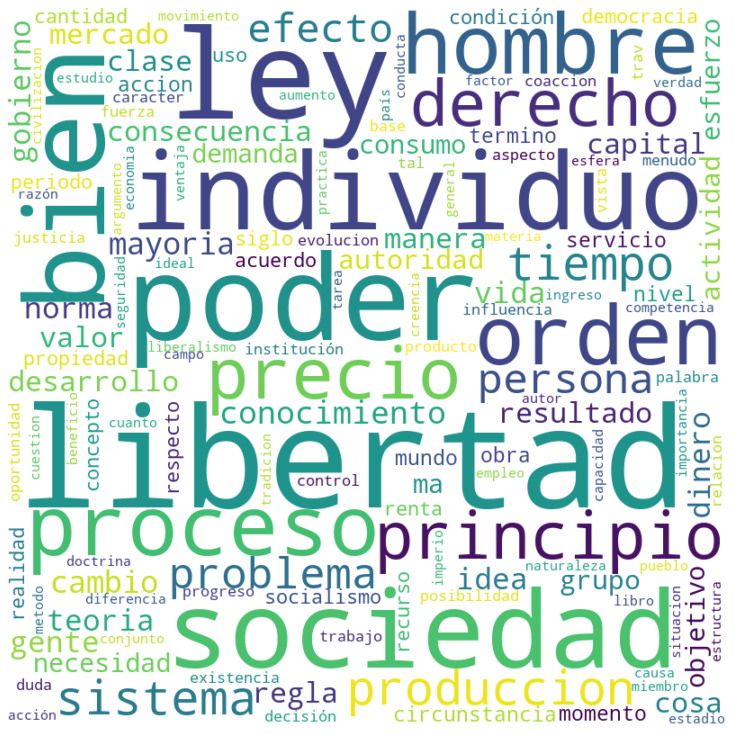

In [116]:
text = " ".join(corpus_completo)

wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [117]:
frec_df=pd.DataFrame(list(zip(bow[0], frecuenciaPalab_docs[0])))
frec_df.columns=['palabra','frec']
frec_df.drop_duplicates(inplace=True)
frec_df.sort_values(by='frec',ascending=False,inplace=True)
frec_df.head(20)

,palabra,frec
21,gobierno,46
120,asamblea,43
128,ley,36
34,poder,35
0,democracia,34
20,mayoria,30
166,norma,20
271,autoridad,13
91,tiempo,10
137,apoyo,10


In [118]:
corpus_completo

['democracia',
 'conferencia',
 'autor',
 'institute',
 'public',
 'octubre',
 'reproducida',
 'permiso',
 'texto',
 'principio',
 'orden',
 'concepto',
 'democracia',
 'significado',
 'pena',
 'democracia',
 'defensa',
 'tirania',
 'cuanto',
 'convencion',
 'mayoria',
 'gobierno',
 'democracia',
 'valor',
 'motivo',
 'perdida',
 'fe',
 'democracia',
 'gente',
 'fenomeno',
 'momento',
 'palabra',
 'democracia',
 'limit',
 'poder',
 'gobierno',
 'veces',
 'suma',
 'demanda',
 'doquier',
 'nombre',
 'democracia',
 'manera',
 'persona',
 'reaccion',
 'democracia',
 'cuanto',
 'peligro',
 'peligro',
 'confianza',
 'democracia',
 'contenido',
 'concepto',
 'democracia',
 'connotación',
 'significado',
 'metodo',
 'toma',
 'decisión',
 'sucediendo',
 'proposito',
 'democracia',
 'siglo',
 'metodo',
 'decisión',
 'pretexto',
 'advenimiento',
 'democracia',
 'siglo',
 'cambio',
 'ambito',
 'poder',
 'gobierno',
 'siglo',
 'esfuerzo',
 'poder',
 'gobierno',
 'desarrollo',
 'constitución',
 'obj

#Display semantic space

In [119]:
import gensim.corpora as corpora

# Create Dictionary
#Listado de palabras únicas
id2word = corpora.Dictionary(bow)

# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in bow]

# View
print(corpus[:1][0][:30])

[(0, 6), (1, 1), (2, 2), (3, 4), (4, 7), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 10), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 43), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 13)]


In [120]:
!cp "drive/MyDrive/Colab Notebooks/Historical Text Analytics/embbedings/SBW-vectors-300-min5.txt" /content


In [121]:
model = gensim.models.KeyedVectors.load_word2vec_format("SBW-vectors-300-min5.txt", binary=False)

In [122]:
data=model.most_similar(positive=['crédito', 'hombre']) 

In [123]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords) 

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


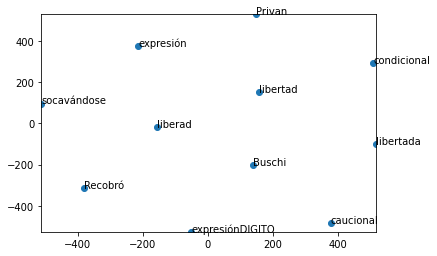

In [124]:
display_closestwords_tsnescatterplot(model, "libertad")

#Análisis de n-grams

In [125]:
def initialize_ngram_finder(list_of_tokens):
    """
    This function will initialize ngram finders for both bigrams & trigrams.
    
    arguments:
        input_text: "list_of_tokens" of type "list" containing all alphanum tokens for each article.
                    
    return:
        value: "bigrams", "trigrams", "bigramFinder", "trigramFinder"
        
    """
    # A number of standard association
    # measures are provided in BigramAssocMeasures and TrigramAssocMeasures.
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    
    # BigramCollocationFinder --> A tool for the finding and ranking of Bigram collocations or other
    # association measures. It is often useful to use from_words() rather than
    # constructing an instance directly.
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(list_of_tokens, window_size=3)
    # TrigramCollocationFinder --> A tool for the finding and ranking of trigram collocations or other
    # association measures. It is often useful to use from_words() rather than
    # constructing an instance directly.
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(list_of_tokens, window_size=3)
    return bigrams, trigrams, bigramFinder, trigramFinder


In [126]:
# bigrams, trigrams, bigramFinder, trigramFinder = initialize_ngram_finder(bow[1])
bigrams, trigrams, bigramFinder, trigramFinder = initialize_ngram_finder(corpus_completo)

In [127]:
def freq_counting_bigram(bigramFinder):
    """
    This function will count how many times adjacent words co-occurs as bigrams.
    
    arguments:
        input_text: "bigramFinder" of type "nltk.collocations.BigramCollocationFinder". 
                    
    return:
        value: "bigramFreqTable" of type "pandas Dataframe" 
                containing bigrams and their corresponding frequencies.
        
    """
    # Generate list of bigrams w.r.t their frequency.
    bigram_freq = bigramFinder.ngram_fd.items()
    # Create Dataframe having bigrams as one column & their corresponding frequency as other column 
    # sorted in descending order of frequency.
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
    freq_bi = bigramFreqTable[:100].bigram.values
    return bigramFreqTable, freq_bi


In [128]:
bigramFreqTable, freq_bi = freq_counting_bigram(bigramFinder)
bigramFreqTable.head(10).reset_index(drop=True)


,bigram,freq
0,"(bien, consumo)",237
1,"(libertad, libertad)",167
2,"(demanda, bien)",156
3,"(imperio, ley)",129
4,"(bien, produccion)",122
5,"(produccion, bien)",114
6,"(cantidad, dinero)",100
7,"(precio, bien)",97
8,"(demanda, consumo)",89
9,"(ley, ley)",86


In [129]:
bigramFreqTable

,bigram,freq
27740,"(bien, consumo)",237
3531,"(libertad, libertad)",167
32147,"(demanda, bien)",156
287,"(imperio, ley)",129
32128,"(bien, produccion)",122
...,...,...
57820,"(poblacion, materia)",1
57819,"(beneplacito, materia)",1
57818,"(beneplacito, poblacion)",1
57817,"(objeto, poblacion)",1


In [130]:
bigramFreqTable_dict=dict(zip(bigramFreqTable.bigram, bigramFreqTable.freq))
# bigramFreqTable_dict

In [131]:
trigramFreqTable, freq_tri = freq_counting_bigram(trigramFinder)
trigramFreqTable.head(10).reset_index(drop=True)

,bigram,freq
0,"(demanda, bien, consumo)",85
1,"(produccion, bien, consumo)",37
2,"(demanda, bien, produccion)",33
3,"(precio, bien, consumo)",30
4,"(cambio, cantidad, dinero)",22
5,"(            ,             ,             )",20
6,"(bien, consumo, demanda)",17
7,"(bien, consumo, bien)",17
8,"(incremento, demanda, bien)",15
9,"(demanda, bien, capital)",14


In [132]:
# freq_bi=freq_bi.reshape(-1,1)
# freq_bi.shape

freq_bi=list(freq_bi)
freq_bi_comp=[]
freq_bi_comp.append(freq_bi)

In [133]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import models

docs = ['new york is is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
# bigram = Phrases(token_, min_count=1, threshold=2,delimiter=b' ')
# bigram = Phrases(bow, min_count=5, threshold=2,delimiter=b' ')

# bigram_phraser = Phraser(bigram)
# bigram_token = []
# for sent in token_:
#     bigram_token.append(bigram_phraser[sent])

phrases = Phrases(bow,min_count=2)
bigrams = Phraser(phrases)    
# bigrams

bigram_token = []
for sent in bow:
    bigram_token.append(bigrams[sent])

# for doc in bow:
#     bigrams_doc = list(ngrams(doc, 2)) 
#     bigram_token.append(bigrams_doc)

In [134]:
corpus_completo_bigramas=[]
for d in bigram_token:
    corpus_completo_bigramas+=d

# corpus_completo_palabras=set(corpus_completo)
# len(corpus_completo_palabras)

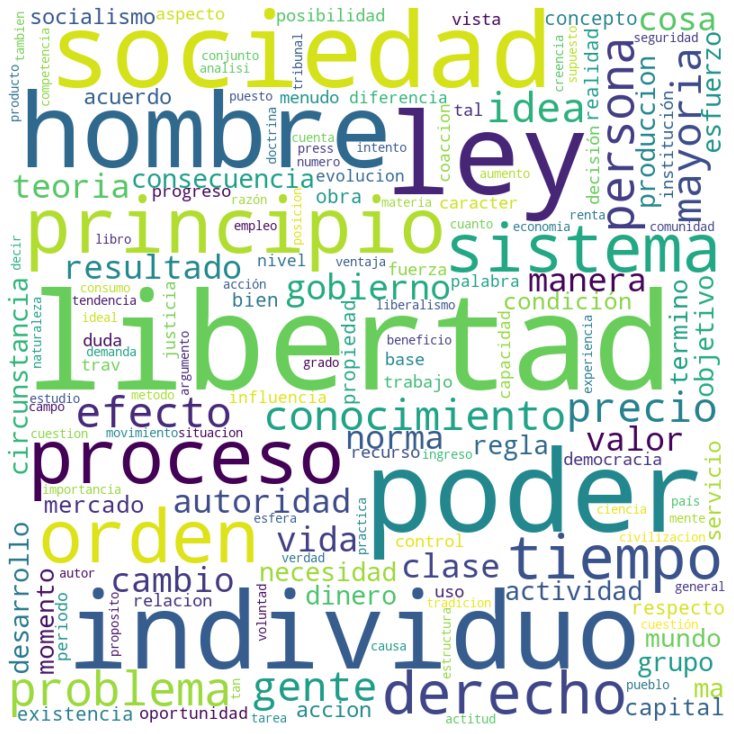

In [135]:
#Todo incluyendo bigramas

text = " ".join(corpus_completo_bigramas)
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [136]:
corpus_completo_bigramas2=list(filter(lambda k: '_' in k, corpus_completo_bigramas))
corpus_completo_bigramas2 = [ele for ele in corpus_completo_bigramas2 if not(ele in 'camino_servidumbre')]

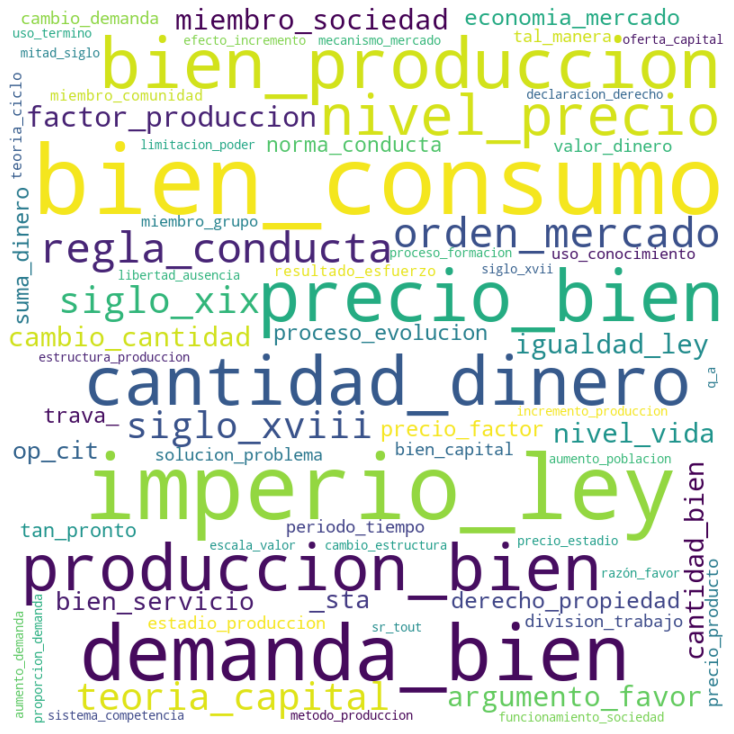

In [137]:
#Solo bigramas
text = " ".join(corpus_completo_bigramas2)

wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [138]:
# id2word = corpora.Dictionary(bow)

# # Term Document Frequency
# corpus = [id2word.doc2bow(t) for t in bow]


import gensim.corpora as corpora

#Listado de bigramas únicos
id2word_bi = corpora.Dictionary(bigram_token)

# Term Document Frequency
corpus_bi = [id2word_bi.doc2bow(t) for t in bigram_token]

# View
print(corpus_bi[:1][0][:30])


[(0, 5), (1, 1), (2, 2), (3, 2), (4, 2), (5, 7), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 10), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 37), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1)]


In [139]:
import gensim.corpora as corpora

# Create Dictionary
#Listado de palabras únicas
id2word = corpora.Dictionary(bow)

# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in bow]

# View
print(corpus[:1][0][:30])

[(0, 6), (1, 1), (2, 2), (3, 4), (4, 7), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 10), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 43), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 13)]


#LDA

In [140]:
%%time

from pprint import pprint

# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       iterations=100,
                                       random_state=100)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"bien" + 0.013*"produccion" + 0.013*"precio" + 0.011*"libertad" + '
  '0.009*"dinero" + 0.008*"ley" + 0.008*"cambio" + 0.007*"consumo" + '
  '0.007*"proceso" + 0.007*"capital"'),
 (1,
  '0.013*"libertad" + 0.007*"ley" + 0.007*"poder" + 0.006*"proceso" + '
  '0.006*"individuo" + 0.006*"sociedad" + 0.005*"orden" + 0.005*"principio" + '
  '0.005*"hombre" + 0.005*"bien"'),
 (2,
  '0.011*"libertad" + 0.010*"ley" + 0.009*"poder" + 0.008*"individuo" + '
  '0.008*"sociedad" + 0.007*"orden" + 0.007*"hombre" + 0.007*"principio" + '
  '0.007*"derecho" + 0.006*"sistema"')]
CPU times: user 306 ms, sys: 270 ms, total: 576 ms
Wall time: 629 ms


In [141]:
import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim
# import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#     LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    # with open(LDAvis_data_filepath, 'wb') as f:
    #     pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, 'results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
2     -0.019521  0.0       1        1  80.507704
0      0.024895  0.0       2        1  14.280662
1     -0.005374  0.0       3        1   5.211634, topic_info=             Term         Freq        Total Category  logprob  loglift
209      libertad  1111.000000  1111.000000  Default  30.0000  30.0000
809          bien   450.000000   450.000000  Default  29.0000  29.0000
208           ley   964.000000   964.000000  Default  28.0000  28.0000
280        precio   411.000000   411.000000  Default  27.0000  27.0000
273         poder   855.000000   855.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
164         gente    18.480253   404.742205   Topic3  -5.6566  -0.1323
71   conocimiento    20.279886   488.461278   Topic3  -5.5637  -0.2274
108       derecho    21.269437   627.472202   Topic3  -5.5161  -0.4302
241         norma    17.251692   428.087805   Topic3  -5.7254  -0.2571
280        precio    16.858562   411.575231   Topic3  -5.7485  -0.2409

[279 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3650      1  0.217099   abanico
3650      2  0.651298   abanico
0         1  0.874015    accion
0         2  0.087753    accion
0         3  0.038611    accion
...     ...       ...       ...
375       3  0.031360  voluntad
3180      1  0.731652     wells
3194      1  0.830218         ©
3194      2  0.105845         ©
3194      3  0.062845         ©

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

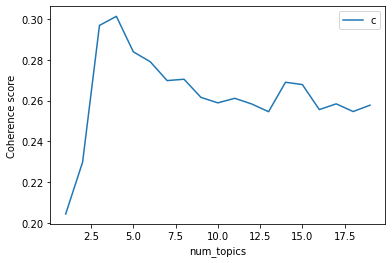

([<gensim.models.ldamodel.LdaModel at 0x7f1585dac850>,
 [0.20439198791187807,
  0.22981328692048103,
  0.2970011163435248,
  0.3014470500700192,
  0.2840420075965632,
  0.2791709560848713,
  0.26989861047879693,
  0.2705584209060957,
  0.26165539887264383,
  0.25896545078581423,
  0.2612002738771092,
  0.2584181854659238,
  0.2546191857026758,
  0.2690851385250556,
  0.2679312916297651,
  0.2556679197802439,
  0.25846796818259904,
  0.2547009761623683,
  0.2578260427784029])

In [142]:
evaluate_graph(id2word,corpus,bow,20,'lda')

In [143]:
lda_model.show_topics()


[(0,
  '0.015*"bien" + 0.013*"produccion" + 0.013*"precio" + 0.011*"libertad" + 0.009*"dinero" + 0.008*"ley" + 0.008*"cambio" + 0.007*"consumo" + 0.007*"proceso" + 0.007*"capital"'),
 (1,
  '0.013*"libertad" + 0.007*"ley" + 0.007*"poder" + 0.006*"proceso" + 0.006*"individuo" + 0.006*"sociedad" + 0.005*"orden" + 0.005*"principio" + 0.005*"hombre" + 0.005*"bien"'),
 (2,
  '0.011*"libertad" + 0.010*"ley" + 0.009*"poder" + 0.008*"individuo" + 0.008*"sociedad" + 0.007*"orden" + 0.007*"hombre" + 0.007*"principio" + 0.007*"derecho" + 0.006*"sistema"')]

#LDA con bigramas


In [144]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model_bi = gensim.models.LdaMulticore(corpus=corpus_bi,
                                       id2word=id2word_bi,
                                       num_topics=num_topics,
                                       iterations=100,
                                       random_state=100)

# Print the Keyword in the 10 topics
pprint(lda_model_bi.print_topics())
doc_lda_bi = lda_model_bi[corpus]
lda_model_bi[corpus[0]]

[(0,
  '0.013*"libertad" + 0.009*"poder" + 0.007*"derecho" + 0.007*"ley" + '
  '0.006*"principio" + 0.006*"individuo" + 0.006*"sociedad" + 0.006*"persona" '
  '+ 0.006*"hombre" + 0.005*"gente"'),
 (1,
  '0.014*"libertad" + 0.009*"ley" + 0.008*"individuo" + 0.007*"poder" + '
  '0.007*"principio" + 0.007*"hombre" + 0.007*"tiempo" + 0.007*"sociedad" + '
  '0.006*"orden" + 0.006*"mayoria"'),
 (2,
  '0.009*"proceso" + 0.008*"produccion" + 0.007*"precio" + 0.007*"dinero" + '
  '0.006*"teoria" + 0.006*"problema" + 0.005*"capital" + 0.005*"libertad" + '
  '0.005*"cambio" + 0.005*"conocimiento"'),
 (3,
  '0.016*"libertad" + 0.008*"hombre" + 0.007*"individuo" + 0.007*"sociedad" + '
  '0.007*"poder" + 0.006*"sistema" + 0.006*"ley" + 0.006*"vida" + '
  '0.005*"derecho" + 0.005*"principio"'),
 (4,
  '0.012*"libertad" + 0.010*"poder" + 0.008*"ley" + 0.008*"sociedad" + '
  '0.008*"hombre" + 0.007*"principio" + 0.007*"individuo" + 0.006*"proceso" + '
  '0.005*"problema" + 0.005*"persona"'),
 (5,
  '0.

[(4, 0.06816505), (6, 0.9309852)]

In [145]:
import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim
# import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared_bi = pyLDAvis.gensim.prepare(lda_model_bi, corpus_bi, id2word_bi)
#     LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    # with open(LDAvis_data_filepath, 'wb') as f:
    #     pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, 'results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared_bi

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.002893 -0.003151       1        1  51.423723
2     -0.033095  0.000111       2        1  19.817989
3      0.012173 -0.004048       3        1  11.447530
5      0.002784  0.004465       4        1   9.049032
8      0.009752 -0.001267       5        1   2.870558
9      0.000140  0.006661       6        1   2.469161
7     -0.002306  0.000022       7        1   1.778256
6     -0.009626 -0.003330       8        1   1.141666
1      0.012005  0.005208       9        1   0.001042
0      0.011068 -0.004672      10        1   0.001042, topic_info=             Term         Freq        Total Category  logprob  loglift
215      libertad  1051.000000  1051.000000  Default  30.0000  30.0000
281         poder   782.000000   782.000000  Default  29.0000  29.0000
214           ley   656.000000   656.000000  Default  28.0000  28.0000
350      sociedad   655.000000   655.000000  Default  27.0000  27.0000
295     principio   575.000000   575.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
297      problema     0.003533   487.950986  Topic10  -5.6482  -0.3641
261         orden     0.003298   435.077870  Topic10  -5.7173  -0.3184
114    desarrollo     0.002804   294.211505  Topic10  -5.8793  -0.0893
288        precio     0.002961   404.837166  Topic10  -5.8249  -0.3540
75   conocimiento     0.002899   425.536173  Topic10  -5.8461  -0.4251

[870 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.622342  accion
0         2  0.101517  accion
0         3  0.097103  accion
0         4  0.092689  accion
0         5  0.026483  accion
...     ...       ...     ...
3340      5  0.041667   ©_sta
6740      1  0.350818       ·
6740      2  0.263114       ·
6740      3  0.087705       ·
6740      4  0.175409       ·

[1883 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 6, 9, 10, 8, 7, 2, 1])

#Tópicos dentro el espacio semántico

In [146]:
import numpy as np
from gensim.test.utils import datapath
from gensim import utils

l = np.array([0.017*model.get_vector("libertad"), 0.009*model.get_vector("precio"), 0.008*model.get_vector("poder"),0.007*model.get_vector("bien"),0.007*model.get_vector("hombre"), 0.006*model.get_vector("produccion"), 0.006*model.get_vector("ley")])


In [147]:
from numpy import *
def randCent(dataSet, k, s):
    n = shape(dataSet)[1]
    centroids = mat(zeros(n))
    for j in range(n):
        centroids[:,j] = np.sum(dataSet[:,j])
    return centroids/s

In [148]:
s=0.017+0.009+0.008+0.007+0.007+0.006+0.006
centroid=randCent(l,1, s)
centroid=centroid.getA1()

In [149]:
model.similar_by_vector(centroid)

[('libertad', 0.7767316102981567),
 ('creérsele', 0.7446049451828003),
 ('socavándose', 0.7387365102767944),
 ('lucharlas', 0.735815167427063),
 ('monopolizarla', 0.7315989136695862),
 ('coartara', 0.7308528423309326),
 ('restituirnos', 0.7286457419395447),
 ('encausarla', 0.7283784747123718),
 ('desposeidos', 0.7270509600639343),
 ('Averiguan', 0.7263656258583069)]

In [150]:
s=0.011+0.009+0.008+0.007+0.006+0.006+0.006
l = np.array([0.011*model.get_vector("ley"), 0.009*model.get_vector("libertad"), 0.008*model.get_vector("poder"),0.007*model.get_vector("principio"),0.006*model.get_vector("individuo"), 0.006*model.get_vector("sociedad"), 0.006*model.get_vector("proceso")])
centroid=randCent(l,1, s)
centroid=centroid.getA1()

In [151]:
model.similar_by_vector(centroid)

[('coartara', 0.7556817531585693),
 ('separársele', 0.744306206703186),
 ('socavándose', 0.7419633269309998),
 ('portaliano', 0.7410425543785095),
 ('Guzmancista', 0.7404754161834717),
 ('Sustentados', 0.7395446300506592),
 ('comprobársele', 0.7392594218254089),
 ('narcotización', 0.7388145327568054),
 ('principismo', 0.7371867895126343),
 ('podérsele', 0.7356439232826233)]

#Documentos en espacio LDA y espacio semántico

In [152]:
#lda_model[corpus[20]]

In [153]:
lda_model_app=[]
for d in corpus:
  lda_model_app.append(lda_model[d])

pd.DataFrame(lda_model_app)

,0,1
0,"(2, 0.9991863)",None
1,"(1, 0.37531057)","(2, 0.62466025)"
2,"(0, 0.25542414)","(2, 0.7442182)"
3,"(2, 0.9996245)",None
4,"(0, 0.99994814)",None
5,"(2, 0.9953743)",None
6,"(2, 0.99972254)",None
7,"(2, 0.99982995)",None
8,"(2, 0.9995591)",None
9,"(2, 0.9971937)",None


#Collocation


In [154]:
def removes(lst,item):
    rems= lst.count(item) # count number of times the item occurs e.g 7 appears twice
    if not rems: # return if item does not occur in the list
        return    
    for i in range(rems): #loop through the number occurrences
        lst.remove(item) #remove each occurrence


In [155]:

import pickle

In [156]:
import pickle
import uuid
class SocialDocument:

    text    = ""
    corpus    = []

    def __init__(self, text, corpus):
        self.text    = text
        self.corpus  = corpus

    def identify(self):
        print("Text: %s"%(self.text))
        print("Corpus: %s"%(self.corpus))


In [166]:
sd0=SocialDocument(doc[0],corpus_1)
sd1=SocialDocument(doc[1],corpus_2)
sd=SocialDocument(doc,corpus_completo)

sd01=SocialDocument(doc[1],corpus_d1)
sd02=SocialDocument(doc[1],corpus_d2)
sd03=SocialDocument(doc[1],corpus_d3)
sd04=SocialDocument(doc[0],corpus_d4)
sd05=SocialDocument(doc[1],corpus_d5)
sd06=SocialDocument(doc[1],corpus_d6)
sd07=SocialDocument(doc[1],corpus_d7)
sd08=SocialDocument(doc[1],corpus_d8)
sd09=SocialDocument(doc[1],corpus_d9)
sd010=SocialDocument(doc[1],corpus_d10)


In [168]:
with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd0.pkl', 'wb') as outp:
    pickle.dump(sd0, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd1.pkl', 'wb') as outp:
    pickle.dump(sd1, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd.pkl', 'wb') as outp:
    pickle.dump(sd, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd01.pkl', 'wb') as outp:
    pickle.dump(sd01, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd02.pkl', 'wb') as outp:
    pickle.dump(sd02, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd03.pkl', 'wb') as outp:
    pickle.dump(sd03, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd04.pkl', 'wb') as outp:
    pickle.dump(sd04, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd05.pkl', 'wb') as outp:
    pickle.dump(sd05, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd06.pkl', 'wb') as outp:
    pickle.dump(sd06, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd07.pkl', 'wb') as outp:
    pickle.dump(sd07, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd08.pkl', 'wb') as outp:
    pickle.dump(sd08, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd09.pkl', 'wb') as outp:
    pickle.dump(sd09, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd010.pkl', 'wb') as outp:
    pickle.dump(sd010, outp, pickle.HIGHEST_PROTOCOL)



#Database de collocations

In [169]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd1.pkl', 'rb') as inpt:
    sd1=pickle.load(inpt)
with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd0.pkl', 'rb') as inpt:
    sd0=pickle.load(inpt)
with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd.pkl', 'rb') as inpt:
    sd=pickle.load(inpt)


with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd01.pkl', 'rb') as inpt:
    sd01=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd02.pkl', 'rb') as inpt:
    sd02=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd03.pkl', 'rb') as inpt:
    sd03=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd04.pkl', 'rb') as inpt:
    sd04=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd05.pkl', 'rb') as inpt:
    sd05=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd06.pkl', 'rb') as inpt:
    sd06=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd07.pkl', 'rb') as inpt:
    sd07=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd08.pkl', 'rb') as inpt:
    sd08=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd09.pkl', 'rb') as inpt:
    sd09=pickle.load(inpt)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd010.pkl', 'rb') as inpt:
    sd010=pickle.load(inpt)

In [176]:
removes(sd.corpus, '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')
removes(sd1.corpus, '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')

##BIGRAMAS

In [ ]:
from nltk import FreqDist

# use to find bigrams, which are pairs of words
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, ngrams
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

In [173]:
bigram_collocation = BigramCollocationFinder.from_words(sd.corpus, 4)
print(bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5))


[('bien', 'consumo'), ('demanda', 'bien'), ('imperio', 'ley'), ('libertad', 'libertad'), ('cantidad', 'dinero')]
249


In [174]:
print(bigram_collocation.ngram_fd[('bien', 'consumo')])
print(bigram_collocation.ngram_fd[('demanda', 'bien')])
print(bigram_collocation.ngram_fd[('imperio', 'ley')])

249
174
131


In [179]:
bigram_collocation = BigramCollocationFinder.from_words(sd0.corpus, 4)
print(bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5))

[('bien', 'consumo'), ('demanda', 'bien'), ('cantidad', 'dinero'), ('q', 'a\x89'), ('demanda', 'consumo')]


In [177]:
bigram_collocation = BigramCollocationFinder.from_words(sd1.corpus, 4)
print(bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5))

[('imperio', 'ley'), ('libertad', 'libertad'), ('siglo', 'xviii'), ('op', 'cit'), ('regla', 'conducta')]


In [184]:

bigram_collocation = BigramCollocationFinder.from_words(sd01.corpus, 4)
print(bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5))
bigram_collocation = BigramCollocationFinder.from_words(sd04.corpus, 4)
print(bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5))

[('democracia', 'democracia'), ('gobierno', 'ley'), ('acuerdo', 'mayoria'), ('incompatibilidad', 'democracia'), ('escribio', 'parlamento')]
[('siglo', 'xix'), ('esfera', 'responsabilidad'), ('siglo', 'xviii'), ('trava', '©'), ('complejidad', 'veces')]


##Trigamas

In [ ]:
from nltk import FreqDist

# use to find bigrams, which are pairs of words
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, ngrams
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures


In [189]:
trigram_collocation = TrigramCollocationFinder.from_words(sd.corpus, 3)
print(trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 5))

[('demanda', 'bien', 'consumo'), ('precio', 'bien', 'consumo'), ('produccion', 'bien', 'consumo'), ('bien', 'consumo', 'demanda'), ('cantidad', 'bien', 'consumo')]


In [190]:
print(trigram_collocation.ngram_fd[('demanda', 'bien', 'consumo')])

85


In [185]:


trigram_collocation = TrigramCollocationFinder.from_words(sd0.corpus, 3)
print(trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 5))



[('demanda', 'bien', 'consumo'), ('precio', 'bien', 'consumo'), ('produccion', 'bien', 'consumo'), ('bien', 'consumo', 'demanda'), ('flujo', 'bien', 'consumo')]


In [186]:
trigram_collocation = TrigramCollocationFinder.from_words(sd1.corpus, 3)
print(trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 5))

[('ideal', 'imperio', 'ley'), ('ley', 'imperio', 'ley'), ('imperio', 'ley', 'ley'), ('principio', 'imperio', 'ley'), ('concepcion', 'imperio', 'ley')]


In [194]:

trigram_collocation = TrigramCollocationFinder.from_words(sd01.corpus, 3)
print(trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 5))
trigram_collocation = TrigramCollocationFinder.from_words(sd07.corpus, 3)
print(trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 5))

[('compromiso', 'norma', 'conducta'), ('obediencia', 'norma', 'conducta'), ('autoridad', 'compromiso', 'norma'), ('limitación', 'gobierno', 'ley'), ('norma', 'conducta', 'aplicacion')]
[('mitad', 'siglo', 'xix'), ('gobierno', 'limitacion', 'poder'), ('pensador', 'siglo', 'xviii'), ('escritor', 'siglo', 'xviii'), ('siglo', 'xviii', 'armonia')]
